# CSCA 5622 Supervised Learning Final Project
Github public link: https://github.com/BasilPanda/CSCA-5622-FINAL

## Project Summary
### Objective
The supervised learning problem I decided to take on is a match predictor for League of Legends Esports teams. I want to be able to better predict the winning team based on past results but also to learn what key factors are the most influential in winning the match. I plan on using a Data Tree Classifier to determine what the most influential features are. The features range from kills, deaths, assists, and towers and objectives taken.

### The Data
The data is publicly available from https://oracleselixir.com/tools/downloads which hosts all match results since 2011.

APA Citation: Oracle's Elixir. (n.d.). Downloads: Oracle's Elixir tools. Oracle's Elixir. https://oracleselixir.com/tools/downloads

## Imports

In [262]:
# Required imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.stats as stats
import seaborn as sns
import sklearn
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import preprocessing, tree
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import f1_score, accuracy_score, make_scorer
from sklearn.tree import DecisionTreeClassifier

def print_df(df):
    """
    Helper to print info and describe of the df
    """
    print(df.info())
    print(df.describe())

In [243]:
# Grabbing our data, for speed we've already downloaded the required data in our local repository.
df_orig = pd.read_csv("2024_esports_data.csv")

C:\Users\eeng2\AppData\Local\Temp\ipykernel_61608\2071031669.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_orig = pd.read_csv("2024_esports_data.csv")


In [244]:
# Check the head of the data
df_orig.head()

,gameid,datacompleteness,url,league,year,split,playoffs,date,game,patch,...,opp_csat25,golddiffat25,xpdiffat25,csdiffat25,killsat25,assistsat25,deathsat25,opp_killsat25,opp_assistsat25,opp_deathsat25
0,10660-10660_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=10660,DCup,2023,NaN,0,2024-01-01 05:13:15,1,13.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10660-10660_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=10660,DCup,2023,NaN,0,2024-01-01 05:13:15,1,13.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10660-10660_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=10660,DCup,2023,NaN,0,2024-01-01 05:13:15,1,13.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10660-10660_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=10660,DCup,2023,NaN,0,2024-01-01 05:13:15,1,13.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10660-10660_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=10660,DCup,2023,NaN,0,2024-01-01 05:13:15,1,13.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data
The data contains every match every played in every single Esports league in the world. The data size and descriptions can be seen below in `df.describe()`.

The key features we're focusing on are the following:
- gamelength
- result (binary win)
- kills
- deaths
- assists
- teamkills
- teamdeaths
- team kpm
- ckpm
- damagetochampions
- dpm
- damagetakenperminute
- wardsplaced
- wpm
- wardskilled
- wcpm
- controlwardsbought
- visionscore
- vspm
- totalgold
- earnedgold
- earned gpm
- goldspent
- monsterkills

In [264]:
# Let's see what datatypes we have and how many columns
print_df(df_orig)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117648 entries, 0 to 117647
Columns: 161 entries, gameid to opp_deathsat25
dtypes: float64(118), int64(20), object(23)
memory usage: 144.5+ MB
None
                year       playoffs           game          patch  \
count  117648.000000  117648.000000  117648.000000  117504.000000   
mean     2024.035292       0.216748       1.678703      14.093903   
std         0.194213       0.412031       0.939304       0.068401   
min      2023.000000       0.000000       1.000000      13.240000   
25%      2024.000000       0.000000       1.000000      14.040000   
50%      2024.000000       0.000000       1.000000      14.100000   
75%      2024.000000       0.000000       2.000000      14.140000   
max      2025.000000       1.000000       5.000000      14.230000   

       participantid     gamelength         result          kills  \
count  117648.000000  117648.000000  117648.000000  117648.000000   
mean       29.583333    1898.142493       

## Data Cleaning

In [265]:
# Wow, 108 columns. We need to clean the NaN/NULL fields out for ease. We're
# going to remove any column that has NULL values for simplicity since there's
# simply too many columns
df_no_nulls = df_orig.dropna(axis=1, how="any")
print_df(df_no_nulls)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117648 entries, 0 to 117647
Data columns (total 35 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gameid                117648 non-null  object 
 1   datacompleteness      117648 non-null  object 
 2   league                117648 non-null  object 
 3   year                  117648 non-null  int64  
 4   playoffs              117648 non-null  int64  
 5   date                  117648 non-null  object 
 6   game                  117648 non-null  int64  
 7   participantid         117648 non-null  int64  
 8   side                  117648 non-null  object 
 9   position              117648 non-null  object 
 10  teamname              117648 non-null  object 
 11  gamelength            117648 non-null  int64  
 12  result                117648 non-null  int64  
 13  kills                 117648 non-null  int64  
 14  deaths                117648 non-null  int64  
 15  

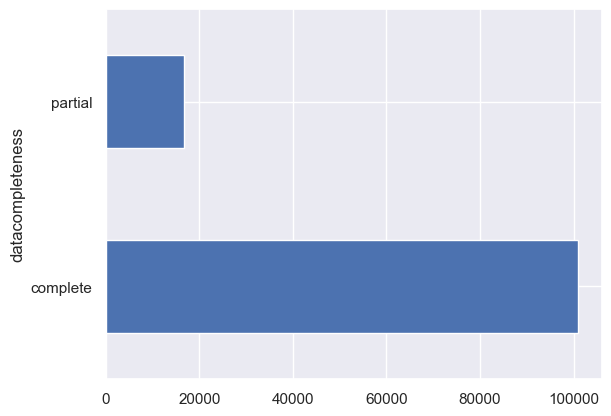

In [268]:
# 138 columns down to 28, nice.
# The dataset has partially duped rows which number close to 20,000. Remove them
# to not pollute our data set further.
df_no_nulls["datacompleteness"].value_counts().plot(kind="barh")
df_no_partials = df_no_nulls[df_no_nulls["datacompleteness"] == "complete"]

In [269]:
# The dataset already sums up all player values to a team.
# We don't really care about per player stats here to predict which team will
# win.
df_teams_only = df_no_partials[df_no_partials["position"] == "team"]

In [271]:
# We're also going to drop columns that aren't really necessary in contributing
# to winning a match
df = df_teams_only.drop(labels=["gameid", "datacompleteness", "year", "playoffs", "date", "game", "participantid", "position"], axis=1)

In [ ]:
# There's team names that are unknown, we need to remove them too otherwise
# we'll seriously pollute our dataset
df = df[df["teamname"] != "unknown team"]

In [ ]:
# We're going to only focus on the major 4 regions and international
# tournaments for simplicity.
# LCK = Korea
# LPL = China
# LEC = Europe
# LCS = America
# WLDs = Worlds
# MSI = Mid Season Invitational
df = df[df["league"].isin(["LCK", "LEC", "LCS", "LPL", "WLDs"])]

In [282]:
# Let's see what datatypes we have and how many columns we have now
print_df(df)

<class 'pandas.core.frame.DataFrame'>
Index: 2174 entries, 754 to 114971
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   league                2174 non-null   object 
 1   side                  2174 non-null   object 
 2   teamname              2174 non-null   object 
 3   gamelength            2174 non-null   int64  
 4   result                2174 non-null   int64  
 5   kills                 2174 non-null   int64  
 6   deaths                2174 non-null   int64  
 7   assists               2174 non-null   int64  
 8   teamkills             2174 non-null   int64  
 9   teamdeaths            2174 non-null   int64  
 10  team kpm              2174 non-null   float64
 11  ckpm                  2174 non-null   float64
 12  damagetochampions     2174 non-null   int64  
 13  dpm                   2174 non-null   float64
 14  damagetakenperminute  2174 non-null   float64
 15  wardsplaced           

In [275]:
# Perfect, we have 27 columns/ key features that all contribute to winning a
# match
print(df.columns)

Index(['league', 'side', 'teamname', 'gamelength', 'result', 'kills', 'deaths',
       'assists', 'teamkills', 'teamdeaths', 'team kpm', 'ckpm',
       'damagetochampions', 'dpm', 'damagetakenperminute', 'wardsplaced',
       'wpm', 'wardskilled', 'wcpm', 'controlwardsbought', 'visionscore',
       'vspm', 'totalgold', 'earnedgold', 'earned gpm', 'goldspent',
       'monsterkills'],
      dtype='object')


In [276]:
# Let's see the head of our data now.
print(df.head())

    league  side      teamname  gamelength  result  kills  deaths  assists  \
754    LEC  Blue      Team BDS        1749       0     10      14       11   
755    LEC   Red    G2 Esports        1749       1     14      10       26   
766    LEC  Blue         Rogue        2080       0      4      16       13   
767    LEC   Red     SK Gaming        2080       1     16       4       43   
778    LEC  Blue  Karmine Corp        2370       0      9      20       16   

     teamkills  teamdeaths  ...  wardskilled    wcpm  controlwardsbought  \
754         10          14  ...           54  1.8525                  31   
755         14          10  ...           48  1.6467                  32   
766          4          16  ...           56  1.6154                  18   
767         16           4  ...           73  2.1058                  53   
778          9          20  ...           58  1.4684                  40   

     visionscore    vspm  totalgold  earnedgold  earned gpm  goldspent  \


## Data Visualizations
Now that our data is clean, we can visualize it now.

### Side Win Rate (Blue or Red)
Notoriously, blue side is known to win more professionally due to pick orders abusing meta picks

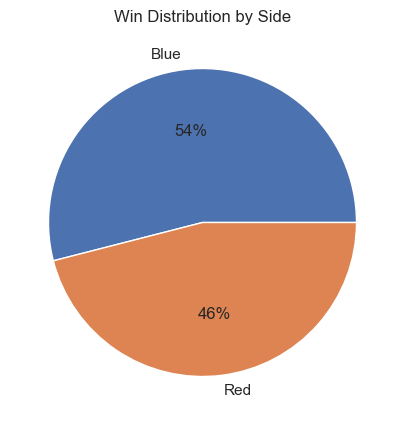

In [277]:
df_winning = df[df["result"] == 1]
counts = df_winning['side'].value_counts()
plt.figure(figsize=(5,5))
plt.title('Win Distribution by Side')
plt.pie(counts, labels=counts.index, autopct='%1.0f%%')
plt.show()

### Highest Gold
Total gold earned for the team is usually a strong influencer for the outcome of the match. Players can use the gold to buy items to become stronger than their opponents.

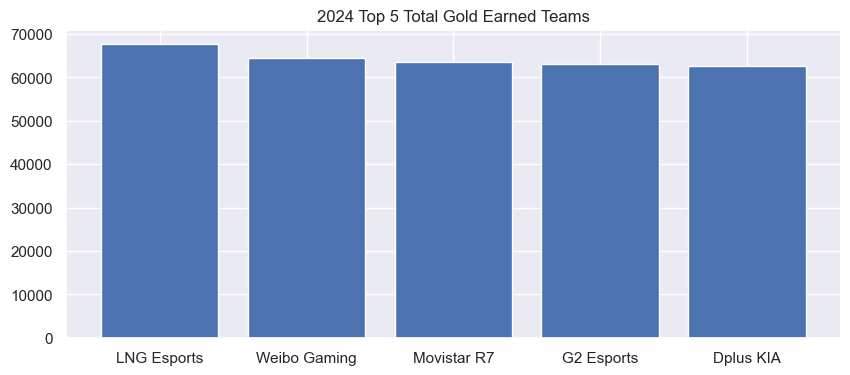

In [278]:
average_gold = df.groupby("teamname")["totalgold"].mean()
top_5_gold = average_gold.sort_values(ascending=0)[:5]
plt.figure(figsize=(10,4))
plt.title('2024 Top 5 Total Gold Earned Teams')
plt.bar(x=top_5_gold.index, height=top_5_gold)
plt.show()

## Exploratory Data Analysis

### Most Winning-est Teams
We know the top 5 gold earning teams, does this correlate to top 5 win rates?

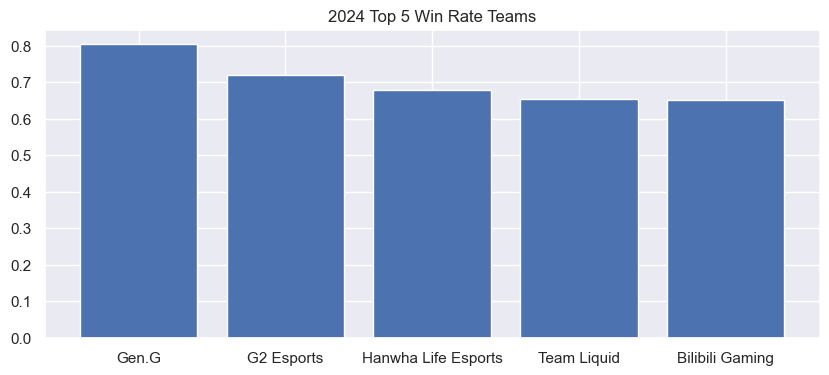

In [279]:
# Get the wins and lost games per team.
df_winning = df[df["result"] == 1]
df_losing = df[df["result"] == 0]
winning_counts = df_winning['teamname'].value_counts()
losing_counts = df_losing['teamname'].value_counts()

# Get the win rates for each team
team_win_rates = {}
for team in winning_counts.index:
    total_games = winning_counts.get(team, 0) + losing_counts.get(team, 0)
    team_win_rates[team] = winning_counts.get(team, 0) / (winning_counts.get(team, 0) + losing_counts.get(team, 0))

team_win_rates = pd.Series(team_win_rates)
top_5 = team_win_rates.sort_values(ascending=0)[:5]
plt.figure(figsize=(10,4))
plt.title('2024 Top 5 Win Rate Teams')
plt.bar(x=top_5.index, height=top_5)
plt.show()

### Bottom 5 Win Rates
For fun, I wanted to see what the bottom 5 teams were.

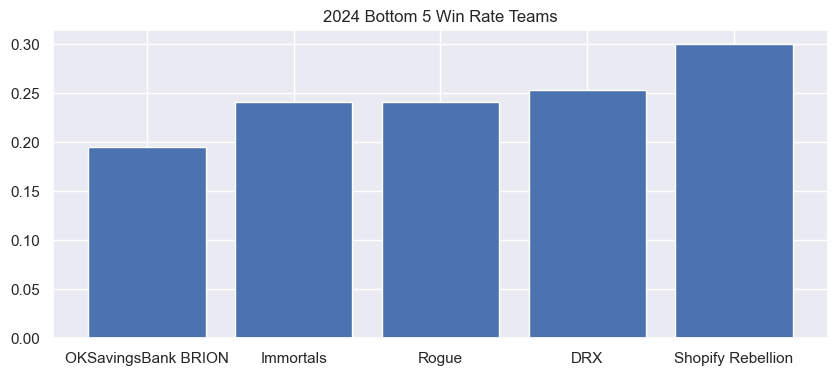

In [280]:
bot_5 = team_win_rates.sort_values(ascending=1)[:5]
plt.figure(figsize=(10,4))
plt.title('2024 Bottom 5 Win Rate Teams')
plt.bar(x=bot_5.index, height=bot_5)
plt.show()

### Who won worlds though?
Worlds is the grandest international tournament for League of Legends similar to the FIFA World Cup for soccer

In [281]:
# Grabbing the last game winner for Worlds
df_worlds = df_teams_only[df_teams_only["league"] == "WLDs"]
df_worlds.iloc[-1]

gameid                      LOLTMNT05_90307
datacompleteness                   complete
league                                 WLDs
year                                   2024
playoffs                                  0
date                    2024-11-02 17:53:48
game                                      5
participantid                           200
side                                    Red
position                               team
teamname                                 T1
gamelength                             1933
result                                    1
kills                                    12
deaths                                    6
assists                                  24
teamkills                                12
teamdeaths                                6
team kpm                             0.3725
ckpm                                 0.5587
damagetochampions                     54493
dpm                               1691.4537
damagetakenperminute            

### The Team That Won 2024 Worlds 
<img src="src/T1_logo.svg.png" alt="Drawing" style="width: 128px;"/>
T1 from LCK (Korea) ended up winning Worlds in 2024 but they weren't even in the top 5 win rate or top 5 total gold earned teams for the year.

### Data Correlation
Okay, so the assumptions I made about win rate and total gold earned clearly don't mean the most in determining a victory. 
I need to convert the remaining categorical data types `league`, `side`, and `teamname` to an integer as they definitely contribute to determining victory.
Let's see what the correlation matrix says then.

<Axes: >

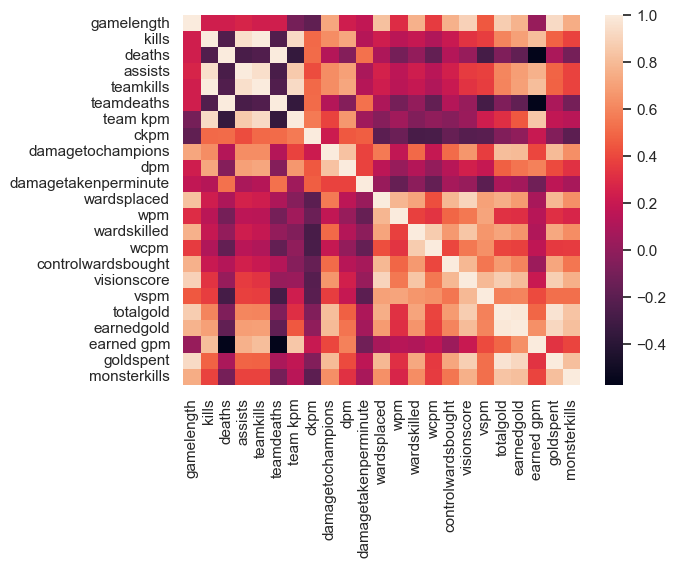

In [ ]:
# Category features we need to convert to integers
cat_features = ["league", "side", "teamname"]

for feature in cat_features:
    # Using LabelEncoder for ease
    label_enc = preprocessing.LabelEncoder()
    label_enc.fit()
    df_no_results = df.drop(columns=["result"])
sns.heatmap(df_no_results.corr())